## Import modules

In [1]:
# import warnings
# warnings.simplefilter("ignore", UserWarning)

import anndata
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc

import scvi

Global seed set to 0
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.

In [2]:
import gc
import torch

In [3]:
import session_info
session_info.show()

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu',)

## Parameters

In [5]:
path_to_adata_gex = '/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw_Multiome.h5ad'
celltype_col = 'mid_grain_mod'
model_architecture_conditions = ['one-layer',
              # 'two-layer',
              # 'three-layer'
                                ]

## Read in anndata

In [6]:
adata = sc.read_h5ad(path_to_adata_gex)
adata

AnnData object with n_obs × n_vars = 211145 × 36601
    obs: 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'fine_grain_aCMs_merged', 'fine_grain_aCMs-node_merged'
    var: 'gene_id'

In [7]:
adata.X.data[:10]

array([2., 1., 1., 2., 1., 2., 1., 2., 1., 1.], dtype=float32)

## Subset anndata

* Only multiome
* Nuclei which are in peak adata (passed ArchR QC)
* Subsampled per fine-grained cell type (max_n=1000)

In [10]:
# read in selected nuclei id
df = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/GEX_ATAC_comparison/subsampled_nuclei_n1000_29Dec2023.txt',
                 header=None)
nuclei_sel = pd.Index(df[0])
print(len(nuclei_sel))
nuclei_sel[:5]

44136


Index(['7089STDY13216921_BHF_F_Hea13242528_TGGGCCTAGATGGACA-1',
       '7089STDY13216921_BHF_F_Hea13242528_AAAGGCTCAGCTACGT-1',
       '7089STDY13216921_BHF_F_Hea13242528_CATCATAAGCGATACT-1',
       '7089STDY13216921_BHF_F_Hea13242528_CAGGCTATCACCAATA-1',
       '7089STDY13216921_BHF_F_Hea13242528_CTAATGTCACTTCATC-1'],
      dtype='object', name=0)

In [11]:
# subset
adata = adata[nuclei_sel]
adata

View of AnnData object with n_obs × n_vars = 44136 × 36601
    obs: 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'fine_grain_aCMs_merged', 'fine_grain_aCMs-node_merged'
    var: 'gene_id'

## Modify mid grained cell type labels: merge CCS and other CMs

In [12]:
# get indices of CCS cells
a_ccs_indices = adata.obs_names[adata.obs['fine_grain'].isin(['SinoatrialNodeCardiomyocytes','AtrioventricularNodeCardiomyocytes'])]
v_ccs_indices = adata.obs_names[adata.obs['fine_grain'].isin(['VentricularConductionSystemProximal','VentricularConductionSystemDistal'])]

# modify: gex data
adata.obs['mid_grain_mod'] = adata.obs['mid_grain'].astype('str').copy()
adata.obs.replace({'mid_grain_mod':{
    'AtrialCardiomyocytes':'AtrialCardiomyocytes_plusCCS',
    'VentricularCardiomyocytes':'VentricularCardiomyocytes_plusCCS'
}},inplace=True)
adata.obs.loc[a_ccs_indices,'mid_grain_mod'] = 'AtrialCardiomyocytes_plusCCS'
adata.obs.loc[v_ccs_indices,'mid_grain_mod'] = 'VentricularCardiomyocytes_plusCCS'
adata.obs['mid_grain_mod'].value_counts()

/tmp/ipykernel_65247/1262357881.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['mid_grain_mod'] = adata.obs['mid_grain'].astype('str').copy()


LymphoidCells                        7006
Fibroblasts                          6969
VentricularCardiomyocytes_plusCCS    6531
AtrialCardiomyocytes_plusCCS         4381
MyeloidCells                         4321
MuralCells                           3103
BloodVesselEndothelialCells          3028
PericardialCells                     2187
Glia                                 1759
EndocardialCells                     1410
EpicardialCells                      1340
Neurons                              1101
LymphaticEndothelialCells            1000
Name: mid_grain_mod, dtype: int64

## Run per condition

* three conditions of complexity

##############################
##### one-layer: LymphaticEndothelialCells #####
##############################
filtered out 15921 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 1 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1000  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 20680 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │          whole sample           │          5          │
│                        │       heart without node        │          6          │
│                        │         left ventricle          │          7          │
│                        │              node               │          8          │
│                        │          outflow tract          │          9          │
│                        │           pericardium           │         10          │
│                        │  pulmonary arches and branches  │         11          │
│                        │         right ventricle         │         12          │
│                        │ right ventricle and papillaries │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:58<00:00,  5.16it/s, loss=7.65e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:58<00:00,  3.37it/s, loss=7.65e+03, v_num=1]


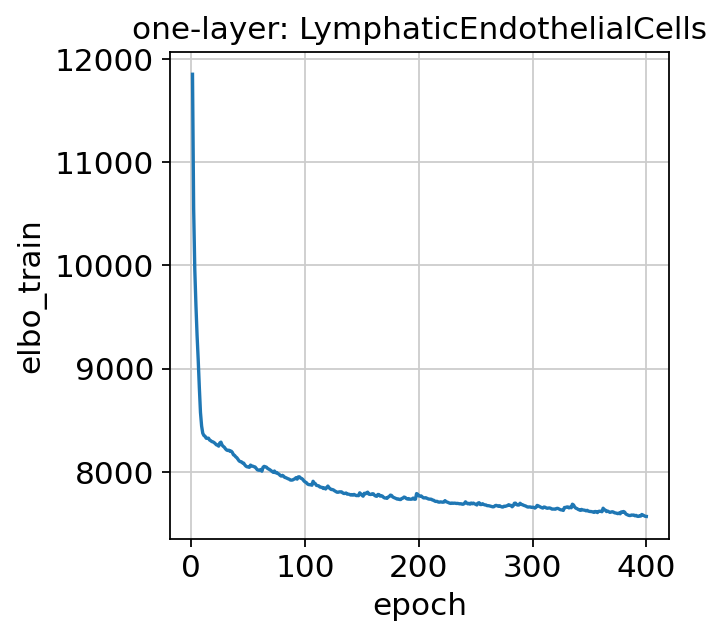


##############################
##### one-layer: LymphoidCells #####
##############################
filtered out 12160 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 4 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 7006  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 24441 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │    Hst33_Nuclei_Multiome-v1     │          5          │
│                        │    Hst36_Nuclei_Multiome-v1     │          6          │
│                        │    Hst39_Nuclei_Multiome-v1     │          7          │
│                        │    Hst40_Nuclei_Multiome-v1     │          8          │
│                        │    Hst41_Nuclei_Multiome-v1     │          9          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              atria              │          1          │
│                        │          atrial septum          │          2          │
│                        │        ductus arteriosus        │          3          │
│                        │          whole sample           │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │           pericardium           │          8          │
│                        │  pulmonary arches and branches  │          9          │
│                        │         right ventricle         │         10          │
│                        │ right ventricle and papillaries │         11          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:14<00:00,  1.38s/it, loss=4.76e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:14<00:00,  1.39s/it, loss=4.76e+03, v_num=1]


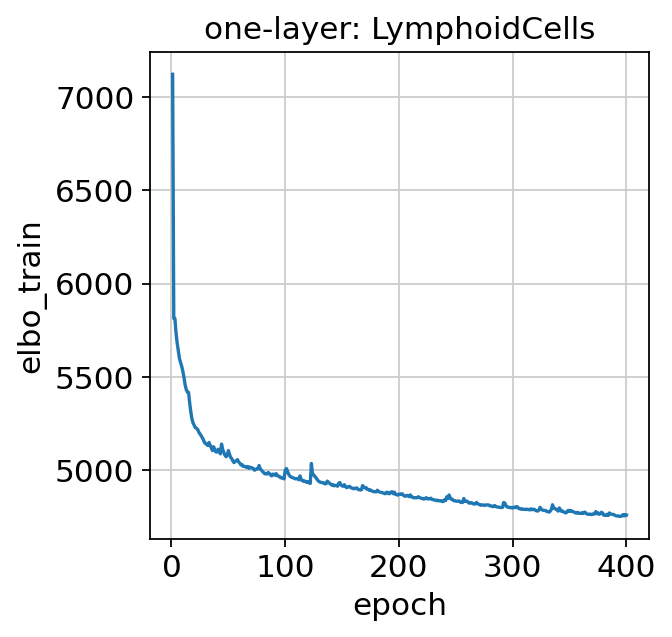


##############################
##### one-layer: MuralCells #####
##############################
filtered out 13545 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 1 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3103  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 23056 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │          whole sample           │          5          │
│                        │       heart without node        │          6          │
│                        │         left ventricle          │          7          │
│                        │              node               │          8          │
│                        │          outflow tract          │          9          │
│                        │           pericardium           │         10          │
│                        │  pulmonary arches and branches  │         11          │
│                        │         right ventricle         │         12          │
│                        │ right ventricle and papillaries │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [04:05<00:00,  1.62it/s, loss=4.98e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [04:05<00:00,  1.63it/s, loss=4.98e+03, v_num=1]


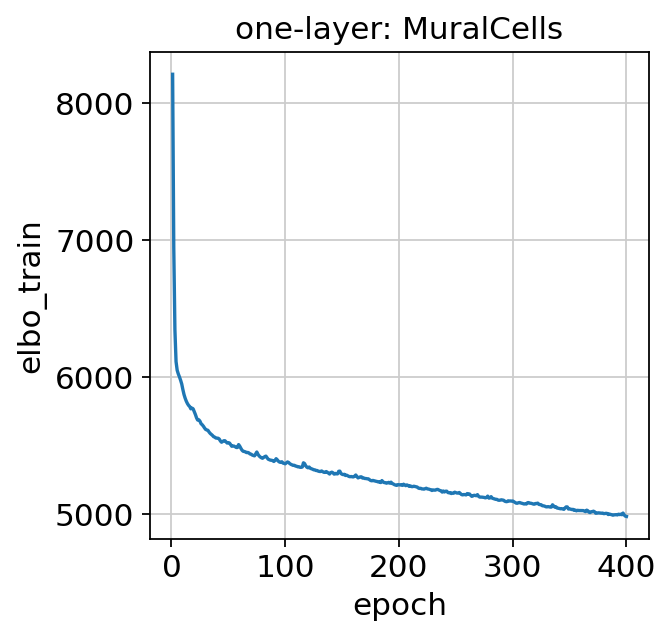


##############################
##### one-layer: VentricularCardiomyocytes_plusCCS #####
##############################
filtered out 12175 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 6531  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 24426 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              apex               │          0          │
│                        │              atria              │          1          │
│                        │          atrial septum          │          2          │
│                        │          whole sample           │          3          │
│                        │       heart without node        │          4          │
│                        │         left ventricle          │          5          │
│                        │              node               │          6          │
│                        │          outflow tract          │          7          │
│                        │         right ventricle         │          8          │
│                        │ right ventricle and papillaries │          9          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:18<00:00,  1.30s/it, loss=6.25e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:18<00:00,  1.25s/it, loss=6.25e+03, v_num=1]


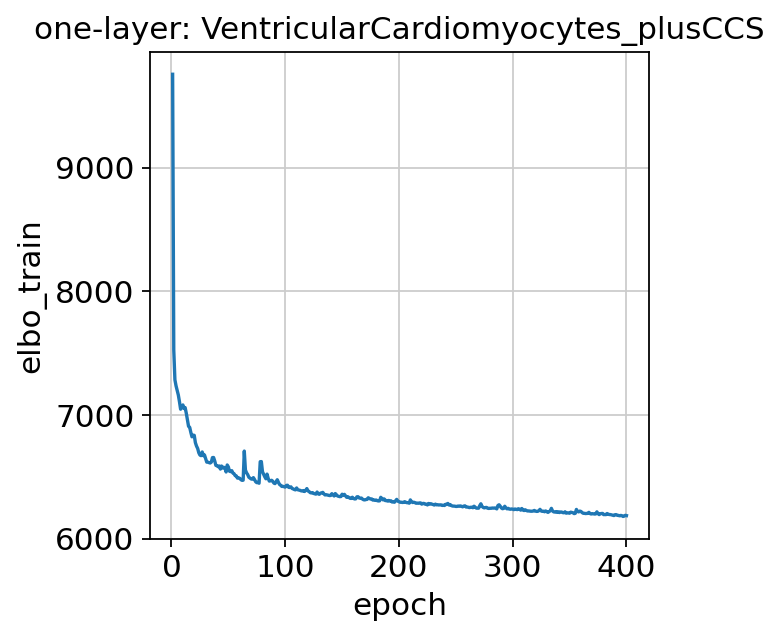


##############################
##### one-layer: Glia #####
##############################
filtered out 15066 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 8 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1759  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 21535 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              atria              │          1          │
│                        │          atrial septum          │          2          │
│                        │        ductus arteriosus        │          3          │
│                        │          whole sample           │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │           pericardium           │          9          │
│                        │  pulmonary arches and branches  │         10          │
│                        │         right ventricle         │         11          │
│                        │ right ventricle and papillaries │         12          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:20<00:00,  2.89it/s, loss=5.82e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:20<00:00,  2.84it/s, loss=5.82e+03, v_num=1]


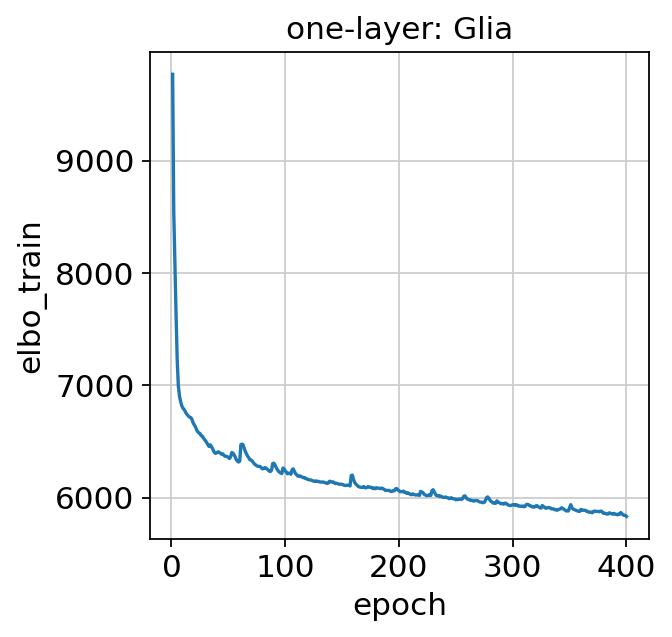


##############################
##### one-layer: MyeloidCells #####
##############################
filtered out 12311 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4321  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 24290 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │          whole sample           │          5          │
│                        │       heart without node        │          6          │
│                        │         left ventricle          │          7          │
│                        │              node               │          8          │
│                        │          outflow tract          │          9          │
│                        │           pericardium           │         10          │
│                        │  pulmonary arches and branches  │         11          │
│                        │         right ventricle         │         12          │
│                        │ right ventricle and papillaries │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [05:34<00:00,  1.15it/s, loss=5.32e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [05:34<00:00,  1.20it/s, loss=5.32e+03, v_num=1]


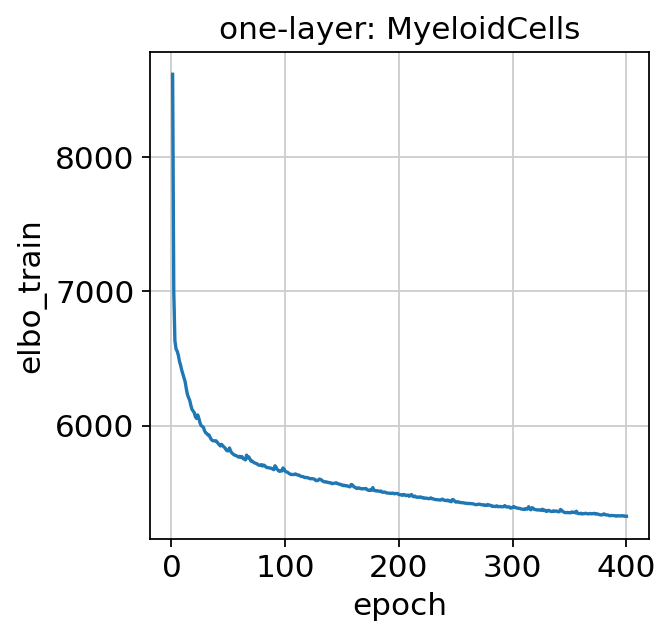


##############################
##### one-layer: PericardialCells #####
##############################
filtered out 14085 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 3 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 0 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2187  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 22516 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     extra_categorical_covs State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │    C87_Nuclei_Multiome-v1     │          0          │
│                        │    C92_Nuclei_Multiome-v1     │          1          │
│                        │    C98_Nuclei_Multiome-v1     │          2          │
│                        │    C104_Nuclei_Multiome-v1    │          3          │
│                        │   Hst39_Nuclei_Multiome-v1    │          4          │
│                        │   Hst40_Nuclei_Multiome-v1    │          5          │
│                        │   Hst41_Nuclei_Multiome-v1    │          6          │
│                        │                               │                     │
│  adata.obs['region']   │             aorta             │          0          │
│                        │         atrial septum         │          1          │
│                        │       ductus arteriosus       │          2          │
│                        │         whole sample          │          3          │
│                        │      heart without node       │          4          │
│                        │         outflow tract         │          5          │
│                        │          pericardium          │          6          │
│                        │ pulmonary arches and branches │          7          │
│                        │                               │                     │
└────────────────────────┴───────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:53<00:00,  2.29it/s, loss=5.98e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:53<00:00,  2.31it/s, loss=5.98e+03, v_num=1]


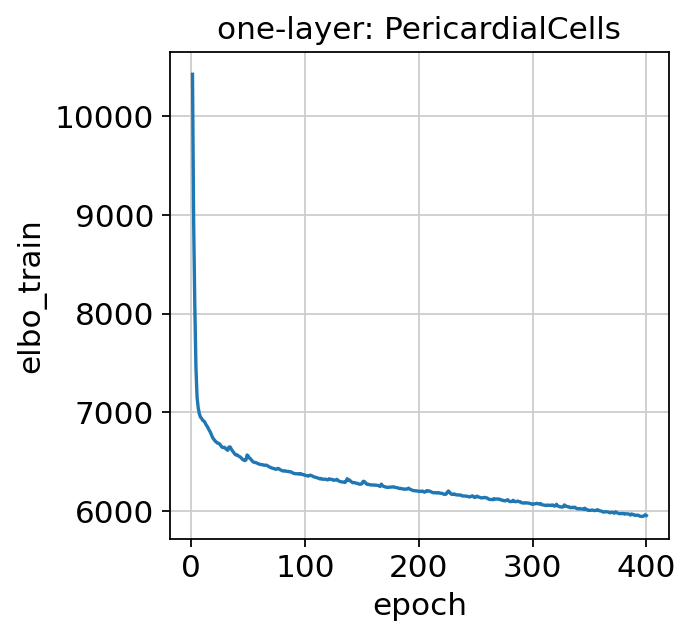


##############################
##### one-layer: BloodVesselEndothelialCells #####
##############################
filtered out 12573 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3028  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 24028 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │          whole sample           │          5          │
│                        │       heart without node        │          6          │
│                        │         left ventricle          │          7          │
│                        │              node               │          8          │
│                        │          outflow tract          │          9          │
│                        │           pericardium           │         10          │
│                        │  pulmonary arches and branches  │         11          │
│                        │         right ventricle         │         12          │
│                        │ right ventricle and papillaries │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:59<00:00,  1.74it/s, loss=6.45e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:59<00:00,  1.67it/s, loss=6.45e+03, v_num=1]


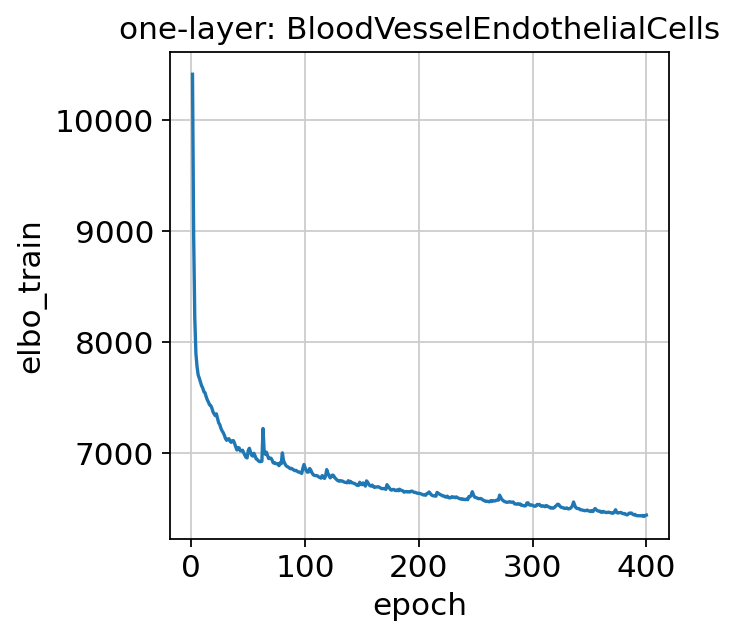


##############################
##### one-layer: EndocardialCells #####
##############################
filtered out 15447 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1410  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 21154 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │          whole sample           │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │         right ventricle         │          9          │
│                        │ right ventricle and papillaries │         10          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:50<00:00,  3.57it/s, loss=6.83e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:50<00:00,  3.61it/s, loss=6.83e+03, v_num=1]


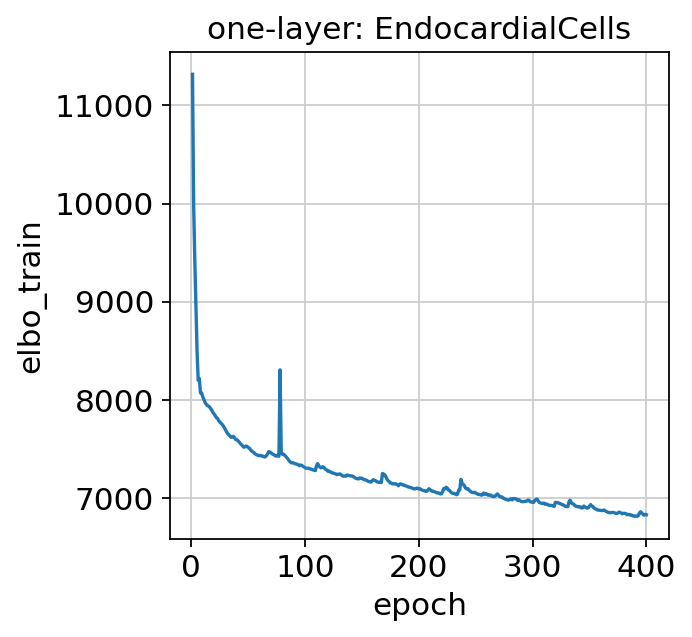


##############################
##### one-layer: EpicardialCells #####
##############################
filtered out 13029 genes that are detected in less than 3 cells


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 13 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1340  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   5   │
│         n_labels         │   1   │
│          n_vars          │ 23572 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │          whole sample           │          5          │
│                        │       heart without node        │          6          │
│                        │         left ventricle          │          7          │
│                        │              node               │          8          │
│                        │          outflow tract          │          9          │
│                        │           pericardium           │         10          │
│                        │  pulmonary arches and branches  │         11          │
│                        │         right ventricle         │         12          │
│                        │ right ventricle and papillaries │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 264/400:  66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 264/400 [01:16<00:38,  3.51it/s, loss=9.89e+03, v_num=1]

In [13]:
%%time
for cond in model_architecture_conditions:
    for celltype in set(adata.obs[celltype_col]):
        print(f'##############################')
        print(f'##### {cond}: {celltype} #####')
        print(f'##############################')

        # subset
        adata_sub = adata[adata.obs[celltype_col]==celltype]
        # filter genes
        sc.pp.filter_genes(adata_sub, min_cells=3)

        # setup anndata for scVI
        adata_sub = adata_sub.copy()
        scvi.model.SCVI.setup_anndata(adata_sub, 
                                  # layer="counts", 
                                  categorical_covariate_keys=['batch_key','region'], # added 'region'
                                  continuous_covariate_keys=['total_counts','pct_counts_mt','pct_counts_ribo',
                                                             'S_score', 'G2M_score'
                                                            ])
        # creating a model
        if cond == 'three-layer':
            vae = scvi.model.SCVI(adata_sub, n_hidden = 128, n_latent = 50, n_layers = 3, dispersion = 'gene-batch')
        elif cond == 'two-layer':
            vae = scvi.model.SCVI(adata_sub, n_hidden=128, n_latent=50, n_layers=2, dispersion = 'gene-batch')
        elif cond == 'one-layer':
            vae = scvi.model.SCVI(adata_sub, n_hidden=128, n_latent=50, n_layers=1, dispersion = 'gene-batch')
        print(vae)
        vae.view_anndata_setup(adata_sub)
        # train
        vae.train()

        # save scvi model
        vae.save(f"/nfs/team205/heart/anndata_objects/Foetal/scVI/models/subsets/Foetal_multiome_{celltype}_{cond}_added-cov-region_subsampled-n1000/",overwrite=True)

        # save scVI lagent space
        adata_sub.obsm["X_scVI"] = vae.get_latent_representation()
        adata_sub.write(f'/nfs/team205/heart/anndata_objects/Foetal/scVI/subsets/Foetal_multiome_{celltype}_{cond}_added-cov-region_subsampled-n1000.h5ad')

        # Convergency plot
        vae.history['elbo_train']
        x = np.linspace(1, (len(vae.history['elbo_train'])), (len(vae.history['elbo_train'])))
        plt.plot(x, vae.history['elbo_train'], label="train")
        plt.xlabel('epoch')
        plt.ylabel('elbo_train')
        plt.title(f'{cond}: {celltype}')
        plt.show()

        del adata_sub, vae
        
        # free up GPU
        gc.collect()
        torch.cuda.empty_cache()
        print('')

In [ ]:
len(set(adata.obs[celltype_col]))